In [45]:
%matplotlib inline 

import matplotlib.pyplot as plt 
import pandas 
import numpy as np
from scipy import interp

from sklearn import ( preprocessing, cross_validation, ensemble, pipeline, 
                      svm, decomposition, grid_search, linear_model, metrics )

In [5]:
df = pandas.read_csv( 'feature_sets/expression_ddg.csv', index_col=0 ) 
print df.sample( 5 ) 

        total  fa_atr  fa_rep  fa_sol  fa_intra_rep  fa_elec  pro_close  \
mutant                                                                    
R240A   0.657   9.367  -0.289 -10.655        -0.016    2.621     -0.014   
Q313R   1.615  -1.249   0.093   2.730         0.006   -0.702     -0.022   
N354A   3.306   6.762   0.367  -6.846        -0.004    1.431      0.011   
T218A   0.241   4.076  -1.701  -6.064        -0.014    1.110      0.015   
L362M  -0.882   0.614  -0.157   0.163        -0.014   -0.197      0.003   

        hbond_bb_sc  hbond_sc   rama  omega  fa_dun  p_aa_pp  yhh_planarity  \
mutant                                                                        
R240A        -0.019     1.880 -0.002    0.0  -3.246   -0.068         -0.001   
Q313R        -0.034    -0.688  0.053    0.0   0.215    0.034         -0.016   
N354A         0.654     1.275  0.129    0.0  -2.916    0.498         -0.019   
T218A         0.004     1.862  0.265    0.0  -0.384    0.511         -0.010   


In [9]:
# scale features and separate into predictors

scl = preprocessing.MaxAbsScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1:].as_matrix().ravel()

print X.shape
print y.shape

(127, 14)
(127,)


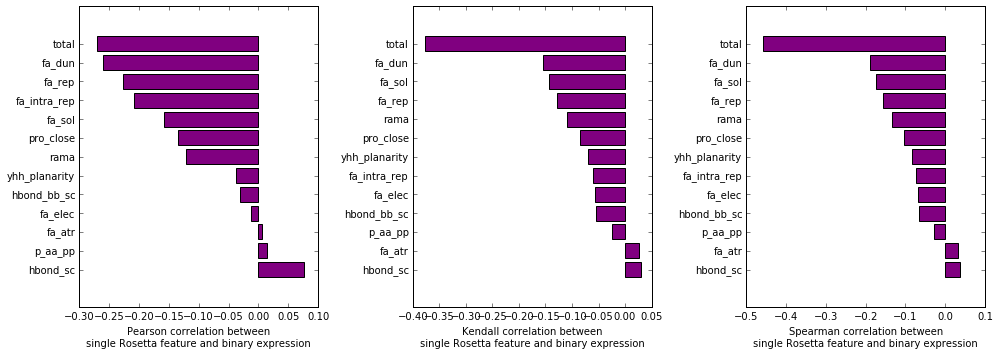

In [34]:
# individual feature correlations
methods = [ 'pearson', 'kendall', 'spearman' ] 
plt.figure( figsize=(14,5) )
for i, method in enumerate( methods ):
    my_corr = df.corr(method=method)['expression'].drop( [ 'expression', 'omega' ] ).sort_values(ascending=False)

    plt.subplot( 1, 3, i+1 )
    plt.barh( range( len( my_corr ) ), my_corr, align='center', color='purple' )
    plt.yticks( range(len( my_corr )), my_corr.index ) 
    plt.xlabel( '{} correlation between\nsingle Rosetta feature and binary expression'.format( method.capitalize() ) ) 
    
plt.tight_layout()

43 samples of class 0
84 samples of class 1


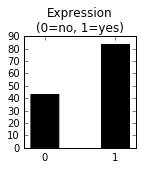

In [36]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [37]:
# if we had more data ... 
#X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)
# instead we will use cross-validation 

In [54]:
# random forest

param_grid = [
    { 
        'rf__max_features': [ 'sqrt', 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])


#my_score = metrics.make_scorer( metrics.matthews_corrcoef )

skf = cross_validation.StratifiedKFold( y, 10 ) 
clf = GridSearchCV( pln, param_grid, cv=skf, scoring='f1_weighted' )
clf.fit( X, y ) 

#print dir( clf ) 
print clf.grid_scores_

[mean: 0.67308, std: 0.15886, params: {'rf__class_weight': 'balanced_subsample', 'rf__max_features': 'sqrt'}, mean: 0.67331, std: 0.13825, params: {'rf__class_weight': 'balanced_subsample', 'rf__max_features': 6}]


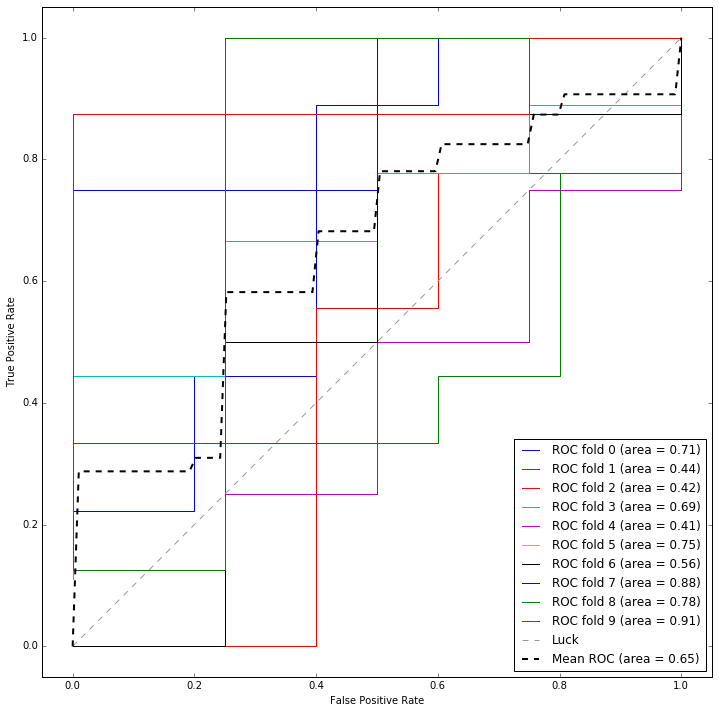

In [ ]:
# logistic regression 
# 10-fold stratified cross validation 

skf = cross_validation.StratifiedKFold( y, 10 )

param_grid = [
    { 
        'logit__class_weight': [ 'balanced' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', linear_model.LogisticRegressionCV() ),
])

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

plt.figure( figsize=( 12, 12 ) ) 

for i, (train, test) in enumerate(skf):
    clf = GridSearchCV( pln, param_grid, cv=10 )
    probas_ = clf.fit(X[train], y[train]).predict_proba(X[test])
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(skf)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np 

iterations = range( 100 ) 
all_scores = []
for i in iterations:
    skf = cross_validation.StratifiedKFold( y, 10, shuffle=True )
    my_scores = cross_val_score( pln, X, y, cv=skf, scoring='precision_weighted' )
    all_scores.append( my_scores.mean() ) 

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
plt.plot( range( 100 ), all_scores ) 
plt.title( 'Stability of logistic regression with shuffled samples' ) 
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'F1 score' ) 

In [ ]:
score, permutation_scores, p_value = permutation_test_score(
    clf, X, y, scoring="f1_weighted", cv=10, n_permutations=100, n_jobs=-1)

In [ ]:
#print("Classification score %s (pvalue : %s)" % (score, p_value))

print 'F1_score={:.2f}, p_value={:.2f}'.format( score, p_value ) 

plt.hist(permutation_scores, 20, label='Permutation scores', color='k', lw=0 )
ylim = plt.ylim()
plt.plot(2 * [score], ylim, '--r', linewidth=2.1, label='F1 score (p={:.2f})'.format( p_value ) )
#plt.plot(2 * [1. / 2], ylim, '--k', linewidth=3, label='Luck')

plt.ylim(ylim)
plt.legend()
plt.xlabel('Score')
plt.xlim( 0, 1 ) 
plt.show()

In [ ]:
plt.figure( figsize=( 16, 3 ) ) 
plt.plot( range( len( permutation_scores ) ), permutation_scores, color='purple' ) 
#plt.plot( enumerate( permutation_scores ) ) 
plt.plot( range( len( all_scores ) ), all_scores, color='green' ) 
plt.title( 'Stability of logistic regression with shuffled samples' ) 
plt.xlabel( 'Number of iterations' )
plt.ylabel( 'F1 score' ) 
plt.legend( [ 'Permutation score', 'Average of 10-fold cross validation' ] ) 

print ' over all iterations'
print 'Mean of permutation scores', np.mean( permutation_scores ).round( 2 ) 
print 'Average of 10-fold cross validation', np.mean( all_scores ).round( 2 ) 

In [ ]:
# random forest

from sklearn.cross_validation import StratifiedKFold

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', RandomForestClassifier() ),
])

# for i in range( 10 ):
    
#     # repeat all this ten times 
    
#     skf = StratifiedKFold( y, 10, shuffle=True ) 
    
    
#     for train_fold, test_fold in skf:
        
#         grid = GridSearchCV( pln, param_grid ) 
        
#         grid.fit( 
    

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [ ]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
y_pred = cross_validation.cross_val_predict( clf, X, y, cv=10 )
#clf.fit( X_train, y_train )

# predict class labels in test set 
#y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

y_true = y 
print classification_report( y_true, y_pred )

y_desc = clf.best_estimator_.named_steps['rf'].predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

In [ ]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

In [ ]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced', None ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets, feature_selection, cross_validation
from sklearn.pipeline import Pipeline

###############################################################################
# Import some data to play with
digits = datasets.load_digits()
y = digits.target
# Throw away data, to be in the curse of dimension settings
y = y[:200]
X = digits.data[:200]
n_samples = len(y)
X = X.reshape((n_samples, -1))
# add 200 non-informative features
X = np.hstack((X, 2 * np.random.random((n_samples, 200))))

###############################################################################
# Create a feature-selection transform and an instance of SVM that we
# combine together to have an full-blown estimator

transform = feature_selection.SelectPercentile(feature_selection.f_classif)

clf = Pipeline([('anova', transform), ('svc', svm.SVC(C=1.0))])

###############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1, 3, 6, 10, 15, 20, 30, 40, 60, 80, 100)

for percentile in percentiles:
    clf.set_params(anova__percentile=percentile)
    # Compute cross-validation score using all CPUs
    this_scores = cross_validation.cross_val_score(clf, X, y, n_jobs=1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

plt.errorbar(percentiles, score_means, np.array(score_stds))

plt.title(
    'Performance of the SVM-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

plt.axis('tight')
plt.show()

In [ ]:
print(__doc__)

import numpy as np
from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold


# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(y, n_folds=6)
classifier = svm.SVC(kernel='linear', class_weight='balanced', probability=True)

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))

plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')

mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 'k--',
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# Split the dataset in two equal parts

from sklearn.ensemble import RandomForestClassifier

my_importances = []

for i in range( 10 ):

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)
    forest = RandomForestClassifier(n_estimators=1000, n_jobs=-1, class_weight='balanced')
    forest.fit(X_train, y_train)

    preds = forest.predict( X_test ) 
    probs = [ i[j] for i, j in zip( forest.predict_proba( X_test ), y_test ) ] 

    tpr, fpr, __ = roc_curve( preds, probs ) 

    plt.plot( tpr, fpr ) 
    plt.xlim( -0.05, 1.05 )
    plt.ylim( -0.05, 1.05 )
    
    my_importances.append( forest.feature_importances_ )

In [ ]:
import pandas 

my_df = pandas.DataFrame( my_importances, columns=df.columns[:-1] )
means = my_df.mean()
st = my_df.std()

print 'Average weight over all iterations' 

my_sorted = means.sort_values(ascending=False)
my_sorted

In [ ]:
plt.title('Feature Importances')

plt.bar( range( len( my_sorted ) ), my_sorted, color='lightblue',
         align='center', lw=0, ecolor='k', yerr=st, error_kw=dict(capsize=0) )
plt.xticks( range( len( my_sorted ) ), my_sorted.index, rotation=90 )            

plt.ylim( 0, .25 )
plt.tight_layout()
plt.show()
